In [2]:
####SETUP

Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'SC'
Preconditioning = 'Precon'  #Precoff or Precon


####################################################
##########
#Options to do different operations in the script.
The_Chosen_Depth = 100
The_Chosen_Depth = 6371-The_Chosen_Depth
Depth_Interest = The_Chosen_Depth
Scale_List = [1,2,3,4,5]
Scale_Interest = Scale_List

##########
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow

####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'



####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Depth_List = np.array([The_Chosen_Depth])

In [1]:
def Get_Orig_Model(Modelfile,Depth_Interest): 
    ##Note that the ModelFile here has to follow the conventions as is imported from the .mat file 
    ##when generated from running the DVmatfile script in wavelets_matlab
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    DvDepthVals = Vvals[0,Depth_Checker]
    ##orig. formulation above

    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    DvDepthVals = Vvals[0,Depth_Checker]
    Face1Map = DvDepthVals[0,0:len(DvDepthVals[0])/6]
    Face2Map = DvDepthVals[0,len(DvDepthVals[0])/6:2*len(DvDepthVals[0])/6]
    Face3Map = DvDepthVals[0,2*len(DvDepthVals[0])/6:3*len(DvDepthVals[0])/6]
    Face4Map = DvDepthVals[0,3*len(DvDepthVals[0])/6:4*len(DvDepthVals[0])/6]
    Face5Map = DvDepthVals[0,4*len(DvDepthVals[0])/6:5*len(DvDepthVals[0])/6]
    Face6Map = DvDepthVals[0,5*len(DvDepthVals[0])/6:6*len(DvDepthVals[0])/6]
    All_map = [Face1Map,Face2Map,Face3Map,Face4Map,Face5Map,Face6Map]
    
    return All_map

def Get_RMS(ModelVals):
    import numpy as np
    rms = np.sqrt(np.mean((abs(ModelVals))**2 )) 
    return rms
    
def Get_Scale_Indices(ModelFile,Scale_Interest,GridName,Database_Path):
    import numpy as np
    Grids = sio.loadmat(Database_Path + GridName)
    ##Find the indices on a single face 
    ##that correspond to a particular scale or set of scales. Best used with basis wavelet maps
    for i in range(np.size(Scale_Interest)):
            Temp_Scale_Checker = np.nonzero(Grids['ScaleIndex'][0,:] == (Scale_Interest[i]))
            if i == 0:
                Scale_Checker = Temp_Scale_Checker
            elif i > 0:
                Scale_Checker = np.concatenate([Scale_Checker,Temp_Scale_Checker],axis=1)
    return(Scale_Checker)
                
def Get_Depth_Wavelet_Coeffs(Modelfile,Depth_Interest): 
    wvcoeffs = ModelFile['wvcoeffs']
    Depth_Checker = np.nonzero(ModelFile['depth'] == (Depth_Interest))
    Wavelet_CoeffsForADepth = wvcoeffs[0,Depth_Checker]
    Wavelet_CoeffsForADepth = Wavelet_CoeffsForADepth[0]
    return(Wavelet_CoeffsForADepth)
    
    
def Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,Modelfile,Depth_Interest,Scale_Interest,Database_Path,ModelBasisName,N):
    NumVals = int(6)*int(2)**(int(2)*int(N))
    WaveletBasis = sio.loadmat(Database_Path + ModelBasisName)
    Grids = sio.loadmat(Database_Path + GridName)
    Depth_Coeffs = Get_Depth_Wavelet_Coeffs(Modelfile,Depth_Interest)
    Scale_Checker = Get_Scale_Indices(ModelFile,Scale_Interest,GridName,Database_Path)
    
    Face1Map = 0;
    Face2Map = 0;
    Face3Map = 0;
    Face4Map = 0;
    Face5Map = 0;
    Face6Map = 0;
    
    for i in range(len(Scale_Checker[0])):
        Curr_Index = Scale_Checker[0][i] 
        Curr_BasisIndex = Curr_Index%(NumVals/6)

                            #    Curr_Coeff = Depth_100_Coeffs[Curr_Index]
        Curr_Coeff = Depth_Coeffs[Curr_Index]
        if Grids['face'][Curr_Index] == 1:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face1Map = Face1Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 2:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face2Map = Face2Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 3:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face3Map = Face3Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 4:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face4Map = Face4Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 5:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face5Map = Face5Map+Curr_Map*Curr_Coeff
        elif Grids['face'][Curr_Index] == 6:
            Curr_Map = (WaveletBasis['Me'][0,Curr_BasisIndex][0].toarray())
            Face6Map = Face6Map+Curr_Map*Curr_Coeff

    All_map =[(np.transpose(Face1Map)).flatten(),(np.transpose(Face2Map)).flatten(),(np.transpose(Face3Map)).flatten(),(np.transpose(Face4Map)).flatten(),(np.transpose(Face5Map)).flatten(),(np.transpose(Face6Map)).flatten()]
    return(All_map)

def RMS_of_Cubed_Sphere(All_map):
    for i in range(len(All_map)):
        if i == 0:
            value = All_map[i]
            value = np.transpose(value)
            Fullvalue = value.flatten()
        elif i > 0:
            value = All_map[i]
            value = np.transpose(value)
            value = value.flatten()
            Fullvalue = np.concatenate([Fullvalue,value],axis=0)
    return(Get_RMS(Fullvalue))

def Plot_Map (All_map,ax,input_title,WaveletBasis,Grids,colormaxinput):
    Nbasis = len(WaveletBasis['Me'][0,:])
    for i in range(len(All_map)):
    #Plot a wavelet from a selected face
        #print(i)

        face = i
        value = All_map[i]
        value = np.transpose(value)
        value = value.flatten()

        N = Grids['MetaN'][0][0]
        ScaleIndex = Grids['ScaleIndex'][0][0]
        #print ScaleIndex
        Jmax = Grids['MetaJmax'][0][0]
        lonwav = Grids['lon'][face*Nbasis:(face+1)*Nbasis]
        latwav = Grids['lat'][face*Nbasis:(face+1)*Nbasis]


        # Define a colorscale
        #colormax=np.amax(abs(value)) #(-colormax,colormax) are the limits of the colorbar (This varies with each face, too risky right now)
        colormax= colormaxinput
        greylimit=0.001*colormax  #this is the limit to which the middle color (grey) will extend on either side of colorttmax mid
        name='r_lgrey_b'
        c = colors.ColorConverter().to_rgb
        colorlist=[c('red'), c('lightgray'), (2.*colormax-2.*greylimit)/(4.*colormax), c('lightgray'),c('lightgray'), (2.*colormax+2.*greylimit)/(4.*colormax), c('lightgray'),c('blue'), 1., c('blue')]
        custom_cmap = make_colormap(colorlist,name)
        register_cmap(name=custom_cmap.name, cmap=custom_cmap)
        palette=custom_cmap.name

        colorVal=get_colors(val=value,xmin=-colormax,xmax=colormax,palette=palette)
        #print colorVal.shape,value.shape,lonwav.shape


        # Make the figure

        m = Basemap(projection='robin', lon_0=0,resolution='c',ax=ax)
        m.drawcoastlines()
        x, y = m(lonwav,latwav); 
        cm = get_cmap(palette)
        sc = ax.scatter(x, y, c=colorVal, vmin=-colormax, vmax=colormax, edgecolor= '', cmap=cm)
        #sc = ax.scatter(x, y, c=colorVal, vmin=-2, vmax=2, edgecolor= '', cmap=cm)

        # Set title
        titlestr  = input_title
        #titlestr='N='+str(N)+', Jmax='+str(Jmax)+ ',Depth='+str(6371-Depth_Interest)+',Scales Used:'+str(Scale_Interest)#'+str(face+1),
        ax.set_title(titlestr,fontsize=12)

        # draw parallels and meridians.
        # labels = [left,right,top,bottom]
        parallels = np.arange(-60,90,30.)
        m.drawparallels(parallels,labels=[False,True,False,False])
        meridians = np.arange(0.,360.,90.)
        m.drawmeridians(meridians,labels=[False,False,False,True])
    return(ax)

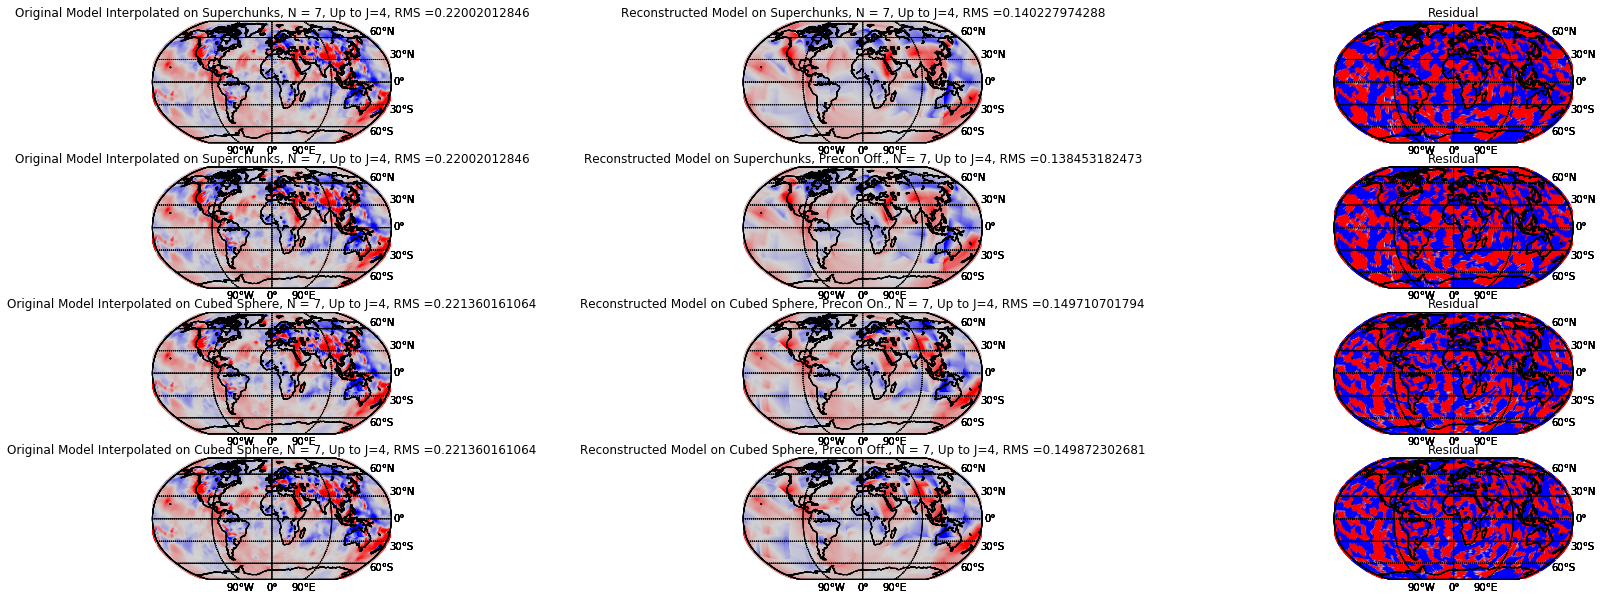

In [3]:
####SETUP

Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'SC'
Preconditioning = 'Precon'  #Precoff or Precon


####################################################
##########
#Options to do different operations in the script.
The_Chosen_Depth = 100
The_Chosen_Depth = 6371-The_Chosen_Depth
Depth_Interest = The_Chosen_Depth
Scale_List = [1,2,3,4,5]
Scale_Interest = Scale_List

##########
#importing standard modules
import math
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import subprocess as sub
import shutil
import sys
import scipy as sci
import scipy.io as sio
%matplotlib inline
from scipy.sparse import csr_matrix, rand
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.pyplot import register_cmap,get_cmap,colorbar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
####################       IMPORT PM's MODULES     ######################################
from plottingPM import get_colors,grayify_cmap,make_colormap,customcolorpalette
from drawmapsection3D import get_distaz,delazgc_helper,writejson,readjson, \
    plot_hotspots,plot_plates,plot_gcpaths,get_fullpath,sanitised_input,uniquenumpyrow

####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'



####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Depth_List = np.array([The_Chosen_Depth])





fig = plt.figure(figsize=(30,10), dpi=300, facecolor='w')


###Orig
Orig_Model = Get_Orig_Model(ModelFile,Depth_Interest)
Orig_RMS = RMS_of_Cubed_Sphere(Orig_Model)
input_title_orig = 'Original Model Interpolated on Superchunks, N = 7, Up to J=4, RMS =' + str(Orig_RMS)
colormaxinput = 0.5
ax1 = fig.add_subplot(431)
Plot_Map(Orig_Model,ax1,input_title_orig,WaveletBasis,Grids,colormaxinput)
###
Full_D4_Reconstruct = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,[5],Database_Path,DVBasisName,N)
D4_Reconstruct_RMS = RMS_of_Cubed_Sphere(Full_D4_Reconstruct)
ax2 = fig.add_subplot(432)
input_title_fullrecon = 'Reconstructed Model on Superchunks, N = 7, Up to J=4, RMS =' + str(D4_Reconstruct_RMS)
Plot_Map(Full_D4_Reconstruct,ax2,input_title_fullrecon,WaveletBasis,Grids,colormaxinput)
###
ax2 = fig.add_subplot(433)
Plot_Map(np.array(Orig_Model) - np.array(Full_D4_Reconstruct),ax2,'Residual',WaveletBasis,Grids,0.005)

###############################
###############################

Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'SC'
Preconditioning = 'Precoff'  #Precoff or Precon


###############################
####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'



####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Depth_List = np.array([The_Chosen_Depth])
###############################
###############################


###SC, precons off.
Orig_Model = Get_Orig_Model(ModelFile,Depth_Interest)
Orig_RMS = RMS_of_Cubed_Sphere(Orig_Model)
input_title_orig = 'Original Model Interpolated on Superchunks, N = 7, Up to J=4, RMS =' + str(Orig_RMS)
colormaxinput = 0.5
ax4 = fig.add_subplot(434)
Plot_Map(Orig_Model,ax4,input_title_orig,WaveletBasis,Grids,colormaxinput)
###
Full_D4_Reconstruct = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,[5],Database_Path,DVBasisName,N)
D4_Reconstruct_RMS = RMS_of_Cubed_Sphere(Full_D4_Reconstruct)
ax5 = fig.add_subplot(435)
input_title_fullrecon = 'Reconstructed Model on Superchunks, Precon Off., N = 7, Up to J=4, RMS =' + str(D4_Reconstruct_RMS)
Plot_Map(Full_D4_Reconstruct,ax5,input_title_fullrecon,WaveletBasis,Grids,colormaxinput)
###
ax6 = fig.add_subplot(436)
Plot_Map(np.array(Orig_Model) - np.array(Full_D4_Reconstruct),ax6,'Residual',WaveletBasis,Grids,0.005)





###############################
###############################

Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'Csph'
Preconditioning = 'Precon'  #Precoff or Precon


###############################
####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'



####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Depth_List = np.array([The_Chosen_Depth])
###############################
###############################


###cubed sphere, precons on.
Orig_Model = Get_Orig_Model(ModelFile,Depth_Interest)
Orig_RMS = RMS_of_Cubed_Sphere(Orig_Model)
input_title_orig = 'Original Model Interpolated on Cubed Sphere, N = 7, Up to J=4, RMS =' + str(Orig_RMS)
colormaxinput = 0.5
ax7 = fig.add_subplot(437)
Plot_Map(Orig_Model,ax7,input_title_orig,WaveletBasis,Grids,colormaxinput)
###
Full_D4_Reconstruct = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,[5],Database_Path,DVBasisName,N)
D4_Reconstruct_RMS = RMS_of_Cubed_Sphere(Full_D4_Reconstruct)
ax8 = fig.add_subplot(438)
input_title_fullrecon = 'Reconstructed Model on Cubed Sphere, Precon On., N = 7, Up to J=4, RMS =' + str(D4_Reconstruct_RMS)
Plot_Map(Full_D4_Reconstruct,ax8,input_title_fullrecon,WaveletBasis,Grids,colormaxinput)
###
ax9 = fig.add_subplot(439)
Plot_Map(np.array(Orig_Model) - np.array(Full_D4_Reconstruct),ax9,'Residual',WaveletBasis,Grids,0.005)
########




#*


###############################
###############################

Database_Path = '../../rem3d/files/'
N = 7
Jmax = 4
WaveletBasisFn = 'D4'
eo =0
EulerConfig = 1
ModelName = 'MIT_P08'
NumVals = int(6)*int(2)**(int(2)*int(N))
Sphere_Param = 'Csph'
Preconditioning = 'Precoff'  #Precoff or Precon


###############################
####More Setup for File Names
##Naming Conventions

DVBasisName = Preconditioning + '_Mmaps.'+ 'N' + str(N) + '.J' + str(Jmax) + '.' + WaveletBasisFn + '.mat'
WaveletCoeffBasisName =  Preconditioning+'_WCoeffs.' + 'N'+str(N) + '.J' + str(Jmax) + '.' + \
                            WaveletBasisFn + '.mat'
GridName= Sphere_Param + '_'+'Grid_N' + str(N) + '_Jmax' + str(Jmax) + \
              '_EulerConfig' + str(EulerConfig) + '.mat'
VeloName = Sphere_Param + '_' + ModelName + '.N' + str(N) + '.Jmax' + str(Jmax) +  \
              '.EulerConfig' + str(EulerConfig) + '.mat'



####Read the .mat files.
WaveletBasis = sio.loadmat(Database_Path + DVBasisName)
WaveletCoeffBasis = sio.loadmat(Database_Path + WaveletCoeffBasisName)
Grids = sio.loadmat(Database_Path + GridName)
ModelFile = sio.loadmat(Database_Path + VeloName)
####
#Declare some variables
Vvals = ModelFile['model']
wvcoeffs = ModelFile['wvcoeffs']
Depths = ModelFile['depth']
Depth_List = np.unique(Depths)
Depth_List = np.flip(Depth_List,0)
Depth_List = np.array([The_Chosen_Depth])
###############################
###############################

#cubed sphere, precons off.
Orig_Model = Get_Orig_Model(ModelFile,Depth_Interest)
Orig_RMS = RMS_of_Cubed_Sphere(Orig_Model)
input_title_orig = 'Original Model Interpolated on Cubed Sphere, N = 7, Up to J=4, RMS =' + str(Orig_RMS)
colormaxinput = 0.5
ax10 = fig.add_subplot(4,3,10)
Plot_Map(Orig_Model,ax10,input_title_orig,WaveletBasis,Grids,colormaxinput)
###
Full_D4_Reconstruct = Construct_Face_Map_From_WaveletCoeffs(wvcoeffs,GridName,ModelFile,Depth_Interest,[5],Database_Path,DVBasisName,N)
D4_Reconstruct_RMS = RMS_of_Cubed_Sphere(Full_D4_Reconstruct)
ax11 = fig.add_subplot(4,3,11)
input_title_fullrecon = 'Reconstructed Model on Cubed Sphere, Precon Off., N = 7, Up to J=4, RMS =' + str(D4_Reconstruct_RMS)
Plot_Map(Full_D4_Reconstruct,ax11,input_title_fullrecon,WaveletBasis,Grids,colormaxinput)
###
ax12 = fig.add_subplot(4,3,12)
Plot_Map(np.array(Orig_Model) - np.array(Full_D4_Reconstruct),ax12,'Residual',WaveletBasis,Grids,0.005)
########



##ROUND NUMBERS